# Testing notebook

In [1]:
from data import Div2k

In [2]:
train_hr_path = f'/home/kareka/ml/SISR/data/HR/train'
train_lr_path = f'/home/kareka/ml/SISR/data/LR_x4/bicubic/train'
val_hr_path = f'/home/kareka/ml/SISR/data/HR/validation'
val_lr_path = f'/home/kareka/ml/SISR/data/LR_x4/bicubic/validation'

train_data = Div2k(train_hr_path, train_lr_path)
valid_data = Div2k(val_hr_path, val_lr_path, subset='valid')

len(train_data), len(valid_data)

(800, 100)

In [3]:
train_data.hr_img_paths[:5]

[PosixPath('/home/kareka/ml/SISR/data/HR/train/0001.png'),
 PosixPath('/home/kareka/ml/SISR/data/HR/train/0002.png'),
 PosixPath('/home/kareka/ml/SISR/data/HR/train/0003.png'),
 PosixPath('/home/kareka/ml/SISR/data/HR/train/0004.png'),
 PosixPath('/home/kareka/ml/SISR/data/HR/train/0005.png')]

In [4]:
train_data.lr_img_paths[:5]

[PosixPath('/home/kareka/ml/SISR/data/LR_x4/bicubic/train/0001x4.png'),
 PosixPath('/home/kareka/ml/SISR/data/LR_x4/bicubic/train/0002x4.png'),
 PosixPath('/home/kareka/ml/SISR/data/LR_x4/bicubic/train/0003x4.png'),
 PosixPath('/home/kareka/ml/SISR/data/LR_x4/bicubic/train/0004x4.png'),
 PosixPath('/home/kareka/ml/SISR/data/LR_x4/bicubic/train/0005x4.png')]

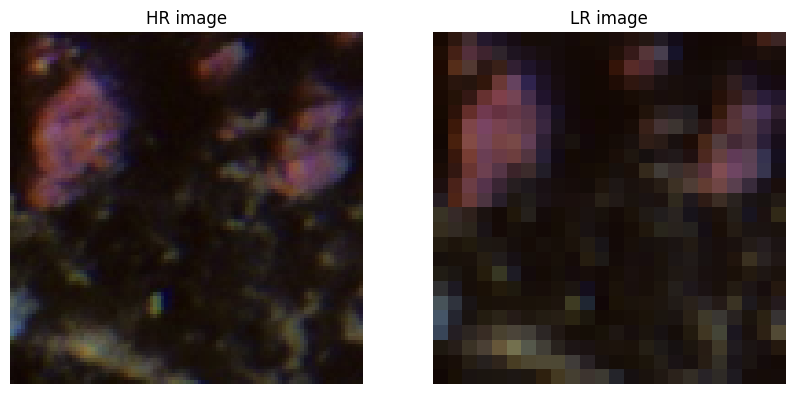

In [5]:
from utils import plot_img
import matplotlib.pyplot as plt

lr_img, hr_img = train_data[0]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plot_img(hr_img.permute(1, 2, 0), "HR image")
plt.subplot(1, 2, 2)
plot_img(lr_img.permute(1, 2, 0), "LR image")

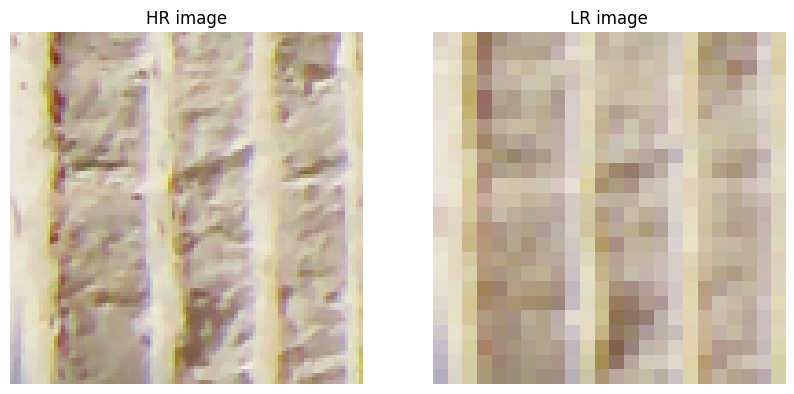

In [24]:
import random

lr_img, hr_img = valid_data[random.randint(0, len(valid_data))]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plot_img(hr_img.permute(1, 2, 0), "HR image")
plt.subplot(1, 2, 2)
plot_img(lr_img.permute(1, 2, 0), "LR image")

In [25]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## DataLoaders

In [26]:
from torch.utils.data import DataLoader

TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 1

tdl = DataLoader(dataset = train_data, batch_size = TRAIN_BATCH_SIZE, shuffle = True)
vdl = DataLoader(dataset = valid_data, batch_size = VALID_BATCH_SIZE, shuffle = False)

## Model

In [27]:
from models.wdsr import wdsr
from torchinfo import summary

model = wdsr(type='b', shape = 3, hidden_units = 64, num_res_blocks = 32, scale = 4).to(device)
summary(model = model, input_size = [TRAIN_BATCH_SIZE, 3, 24, 24])

Layer (type:depth-idx)                   Output Shape              Param #
wdsr                                     [16, 3, 96, 96]           --
├─MeanShift: 1-1                         [16, 3, 24, 24]           (12)
├─Sequential: 1-2                        [16, 3, 96, 96]           --
│    └─upsample: 2-1                     [16, 3, 96, 96]           6
│    │    └─Conv2d: 3-1                  [16, 48, 24, 24]          3,696
│    │    └─PixelShuffle: 3-2            [16, 3, 96, 96]           --
├─Sequential: 1-3                        [16, 64, 24, 24]          --
│    └─Conv2d: 2-2                       [16, 64, 24, 24]          1,856
├─Sequential: 1-4                        [16, 64, 24, 24]          --
│    └─wdsr_b_res_block: 2-3             [16, 64, 24, 24]          --
│    │    └─Sequential: 3-3              [16, 64, 24, 24]          82,304
│    └─wdsr_b_res_block: 2-4             [16, 64, 24, 24]          --
│    │    └─Sequential: 3-4              [16, 64, 24, 24]          82,304


In [28]:
from train import train

In [29]:
EPOCHS = 100
LR = 0.0001
GAMMA = 0.8577

loss_fn = torch.nn.L1Loss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=GAMMA)

model_results, model_train_time = train(model = model,
                                      train_dataloader = tdl,
                                      test_dataloader = vdl,
                                      epochs = EPOCHS,
                                      loss_fn = loss_fn,
                                      optimizer = optimizer,
                                      scheduler = scheduler,
                                      device = device)

  0%|          | 0/100 [00:00<?, ?it/s]

----------------
| Epoch 1/100 |
----------------
---------------------------------------------------------
| Train loss: 0.1120 | Train PSNR: 17.4033 |
| Validation loss: 0.0820 | Validation PSNR: 19.7457 |
Epoch 1 took 112.57 seconds to train and validate
---------------------------------------------------------

----------------
| Epoch 2/100 |
----------------
---------------------------------------------------------
| Train loss: 0.0725 | Train PSNR: 20.6483 |
| Validation loss: 0.0672 | Validation PSNR: 21.2156 |
Epoch 2 took 112.35 seconds to train and validate
---------------------------------------------------------

----------------
| Epoch 3/100 |
----------------
---------------------------------------------------------
| Train loss: 0.0591 | Train PSNR: 22.3919 |
| Validation loss: 0.0551 | Validation PSNR: 23.0531 |
Epoch 3 took 114.53 seconds to train and validate
---------------------------------------------------------

----------------
| Epoch 4/100 |
----------------

---------------------------------------------------------
| Train loss: 0.0340 | Train PSNR: 28.3963 |
| Validation loss: 0.0343 | Validation PSNR: 28.2086 |
Epoch 27 took 113.77 seconds to train and validate
---------------------------------------------------------

----------------
| Epoch 28/100 |
----------------
---------------------------------------------------------
| Train loss: 0.0333 | Train PSNR: 28.5695 |
| Validation loss: 0.0311 | Validation PSNR: 28.2642 |
Epoch 28 took 113.51 seconds to train and validate
---------------------------------------------------------

----------------
| Epoch 29/100 |
----------------
---------------------------------------------------------
| Train loss: 0.0344 | Train PSNR: 28.1425 |
| Validation loss: 0.0343 | Validation PSNR: 28.1546 |
Epoch 29 took 113.54 seconds to train and validate
---------------------------------------------------------

----------------
| Epoch 30/100 |
----------------
-------------------------------------------

---------------------------------------------------------
| Train loss: 0.0320 | Train PSNR: 29.2042 |
| Validation loss: 0.0298 | Validation PSNR: 29.1967 |
Epoch 53 took 114.25 seconds to train and validate
---------------------------------------------------------

----------------
| Epoch 54/100 |
----------------
---------------------------------------------------------
| Train loss: 0.0307 | Train PSNR: 29.6929 |
| Validation loss: 0.0300 | Validation PSNR: 29.3281 |
Epoch 54 took 113.58 seconds to train and validate
---------------------------------------------------------

----------------
| Epoch 55/100 |
----------------
---------------------------------------------------------
| Train loss: 0.0302 | Train PSNR: 29.7190 |
| Validation loss: 0.0330 | Validation PSNR: 28.5970 |
Epoch 55 took 114.41 seconds to train and validate
---------------------------------------------------------

----------------
| Epoch 56/100 |
----------------
-------------------------------------------

---------------------------------------------------------
| Train loss: 0.0313 | Train PSNR: 29.5905 |
| Validation loss: 0.0314 | Validation PSNR: 29.2425 |
Epoch 79 took 114.60 seconds to train and validate
---------------------------------------------------------

----------------
| Epoch 80/100 |
----------------
---------------------------------------------------------
| Train loss: 0.0294 | Train PSNR: 30.2883 |
| Validation loss: 0.0309 | Validation PSNR: 29.3111 |
Epoch 80 took 117.13 seconds to train and validate
---------------------------------------------------------

----------------
| Epoch 81/100 |
----------------
---------------------------------------------------------
| Train loss: 0.0302 | Train PSNR: 30.0376 |
| Validation loss: 0.0295 | Validation PSNR: 30.1531 |
Epoch 81 took 116.07 seconds to train and validate
---------------------------------------------------------

----------------
| Epoch 82/100 |
----------------
-------------------------------------------

In [31]:
from utils import resolve_and_plot_random, compare_with_bicubic, plot_evaluation_curves

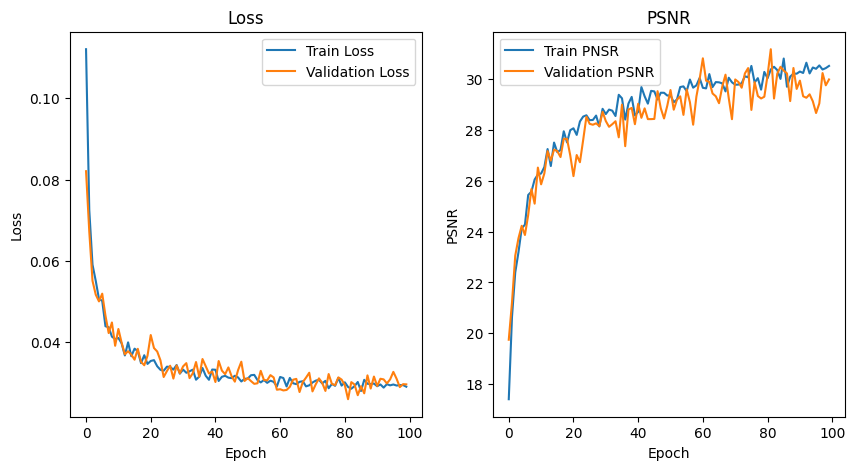

In [32]:
plot_evaluation_curves(model_results)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


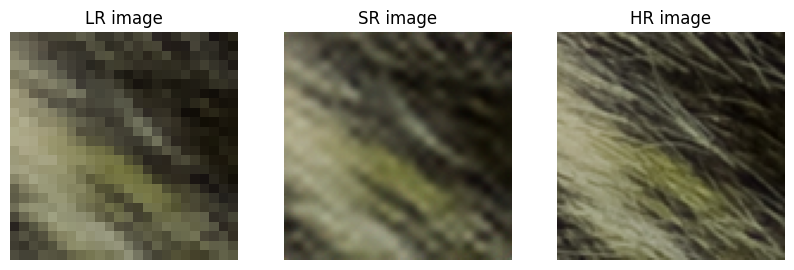

In [39]:
resolve_and_plot_random(model = model, data = valid_data, device = device)

----------------------------------------------------------------
PSNR b/w SR and HR images     : 25.398576736450195
PSNR b/w Bicubic and HR images: 24.703067779541016
----------------------------------------------------------------


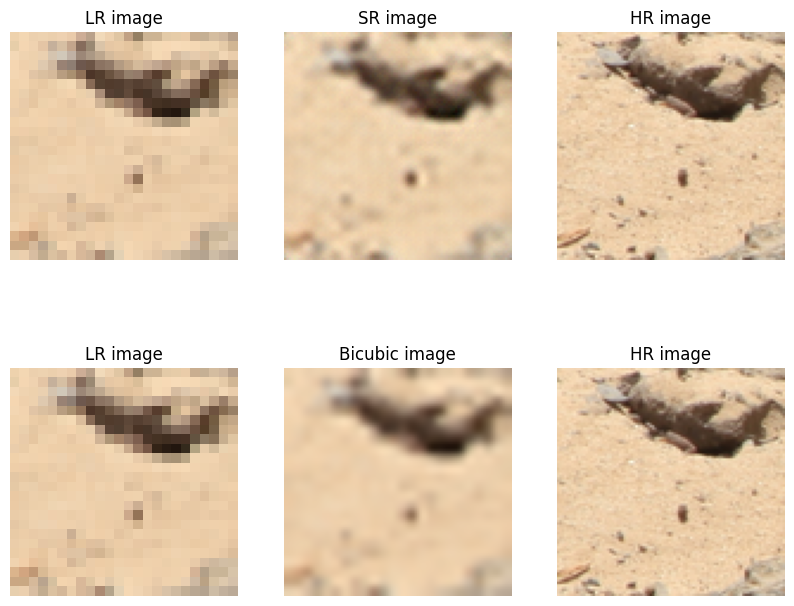

In [47]:
compare_with_bicubic(model = model, data = valid_data, scale = 4, device = device)

In [49]:
from pathlib import Path

save_path = Path('/home/kareka/ml/SISR/weights/wdsr/x4/')
save_path.mkdir(parents=True, exist_ok=True)
name = f"wdsrb-32-x4-L1Loss"
torch.save({
            'epoch': 100,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr': 0.0001,
            'scheduler_state_dict': scheduler.state_dict(),
            'gamma': 0.8577,
            'loss': 'L1Loss',
            }, save_path / name)